In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
def Lorenz63(t, y, sigma=10, beta=8/3, rho=28):
    X, Y, Z = y[0], y[1], y[2]
    dXdt = -sigma*X + sigma*Y
    dYdt = -X*Z + rho*X - Y
    dZdt = X*Y - beta*Z
    return([dXdt, dYdt, dZdt])

In [3]:
t_span = [0,5]
dt = 0.01
x_0 = [-4,10,8]

sol_t = solve_ivp(Lorenz63, t_span, x_0, t_eval=np.arange(t_span[0], t_span[1], dt))
x_t = sol_t.y.T

In [4]:
R = np.diag([0.5]*3)
obs_errors = np.random.multivariate_normal([0,0,0], R, x_t.shape[0])
x_o = x_t + obs_errors 

In [ ]:
sigma, beta, rho = 10, 8/3, 28
P_f_i = np.diag([0.5]*3)
H = np.identity(3)
x_a = np.array([[-5,12,6]]) # Assume some initial error
x_f_i = x_a[0,:]

In [6]:
for ii in np.arange(x_t.shape[0]):

    Ts = ii*dt # Forecast start time
    Ta = (ii+1)*dt # Forecast end time (DA analysis time)

    #--------------
    # Analysis Step
    #--------------

    K_i = P_f_i @ H.T @ np.linalg.inv(H @ P_f_i @ H.T + R) # Compute Kalman gain

    d = x_o[ii, :] - H @ x_f_i # Innovation
    x_a_i = x_f_i + K_i @ d # Update analysis
    P_a_i = (np.identity(3) - K_i @ H) @ P_f_i # plus its error covariance
    
    if ii >= 1:
        x_a = np.vstack([x_a, [x_a_i]]) # Save the analysis output

    #--------------
    # Forecast Step
    #--------------
    
    x_f_i = x_a_i + np.array(Lorenz63(Ts, x_a_i))*dt # Forecast by Euler
    Jcb = np.array([[-sigma,       sigma,    0        ],
                    [rho-x_f_i[2], -1,       -x_f_i[0]],
                    [x_f_i[1],     x_f_i[0], -beta    ]]) # Jacobian
    M_i = np.identity(3) + Jcb*dt # Tangent Linear Model
    P_f_i = M_i @ P_a_i @ M_i.T + np.diag([0.1]*3) # Assume Q = 0.1I

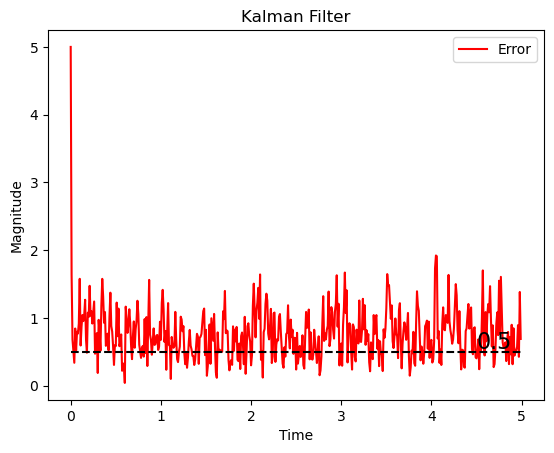

In [ ]:
err = np.sum(np.sqrt((x_a - x_t)**2), axis=1)

plt.plot(np.arange(t_span[0], t_span[1], dt), err, c="r", label="Error")
plt.hlines(0.5,0,5,linestyles="--",colors="k")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Kalman Filter")
plt.text(4.5,0.55,"0.5",fontsize=16)

plt.savefig("Kalman Filter", dpi=300, bbox_inches="tight")
# Again, may be different due to randomness